In [682]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot 
from scipy.stats import shapiro,ttest_ind
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv("laptop_price.csv", encoding='latin-1')
data.Memory = data.Memory.str.replace(r"(1.0)", "1", regex=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [4]:
data["MemorySize1"] = None
data["MemoryType1"] = None
data["MemorySize2"] = None
data["MemoryType2"] = None
data["Width"] = None
data["Height"] = None
data["ppi"] = None
data["Touchscreen"] = "No"
data["Gpu_Model"] = None

for i in range(len(data)):
  data["MemorySize1"][i] = re.findall(r"(\d+[A-Z]+)", data["Memory"][i])[0]
  data["MemoryType1"][i] = re.findall(r"(HDD|SSD|Hybrid|Flash Storage)", data["Memory"][i])[0]
  data["MemorySize2"][i] = (0 if len(re.findall(r"(\d+[A-Z]+)", data["Memory"][i])) == 1 else re.findall(r"(\d+[A-Z]+)", data["Memory"][i])[1])
  data["MemoryType2"][i] = ("No Memory" if len(re.findall(r"(\d+[A-Z]+)", data["Memory"][i])) == 1 else re.findall(r"(HDD|SSD|Hybrid|Flash Storage)", data["Memory"][i])[1])
  if re.match(r"\d+[G][B]", data["MemorySize1"][i]) != None:
    data["MemorySize1"][i] = int(re.sub("\D", "", data["MemorySize1"][i]))
  else:
    data["MemorySize1"][i] = int(re.sub("\D", "", data["MemorySize1"][i]))*1024
  if data["MemorySize2"][i] != 0:
    if re.match(r"\d+[G][B]", data["MemorySize2"][i]) != None:
      data["MemorySize2"][i] = int(re.sub("\D", "", data["MemorySize2"][i]))
    else:
      data["MemorySize2"][i] = int(re.sub("\D", "", data["MemorySize2"][i]))*1024
  data.Ram[i] =  int(re.sub("\D*", "", data.Ram[i]))
  data.Weight[i] = float(re.sub("kg", "", data.Weight[i]))
  data["Height"][i] = int(re.split("x", re.findall(r"\d+x\d+",  data.ScreenResolution[i])[0])[1])
  data["Width"][i] = int(re.split("x", re.findall(r"\d+x\d+",  data.ScreenResolution[i])[0])[0])
  data["ppi"][i] = np.sqrt(data["Height"][i]**2+data["Width"][i]**2)/data["Inches"][i]
  if len(re.findall(r"Touchscreen", data["ScreenResolution"][i]))!=0:
    data["Touchscreen"][i] = "Yes"
  # data["Gpu_Model"][i] = re.sub("Intel |Graphics |Nvidia |GeForce |AMD", "", data["Gpu"][i])

/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [5]:
 data["Cpu_Wname"] = 0
for i in range(len(data.Cpu)):
  data["Cpu_Wname"][i] = re.sub(r"(\s\d*[.]\d*[G][H][z])|(\s\d[G][H][z])", "", data.Cpu[i])
  data["Cpu_Wname"][i] = re.sub(r"Celeron Dual Core", "Celeron", data["Cpu_Wname"][i])
  data["Cpu_Wname"][i] = re.sub(r"Pentium Dual Core", "Pentium", data["Cpu_Wname"][i])
  data["Cpu_Wname"][i] = re.sub(r"Celeron Quad Core", "Celeron", data["Cpu_Wname"][i])
  data["Cpu_Wname"][i] = re.sub(r"Pentium Quad Core", "Pentium", data["Cpu_Wname"][i])



/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

In [6]:
benchmark = pd.read_csv("CPU_UserBenchmarks.csv")

In [7]:
benchmark.Model = benchmark.Model.str.replace("-", " ")
data.Cpu_Wname = data.Cpu_Wname.str.replace("-", " ")

In [8]:
benchmark["Cpu_name"] = benchmark.Brand + " " + benchmark.Model

In [9]:
data["Cpu_Bench"] = None
for i in range(len(data.Cpu_Wname)):
  for j in range(len(benchmark.Cpu_name)):
    if data.Cpu_Wname[i].lower() == benchmark.Cpu_name[j].lower():
      data.Cpu_Bench[i] = benchmark.Benchmark[j]
      continue



/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
data.loc[data.Cpu == "Intel Core i5 1.6GHz", "Cpu_Bench"] = 47.4
data.loc[data.Cpu == "Intel Core i5 2.3GHz", "Cpu_Bench"] = 75.1
data.loc[data.Cpu == "Intel Core i7 2.2GHz", "Cpu_Bench"] = 79
data.loc[data.Cpu == "Intel Core i7 2.8GHz", "Cpu_Bench"] = 70.2
data.loc[data.Cpu == "Intel Core i7 2.9GHz", "Cpu_Bench"] = 69.1
data.loc[data.Cpu == "Intel Core i5 1.3GHz", "Cpu_Bench"] = 47.7
data.loc[data.Cpu == "Intel Core i7 2.7GHz", "Cpu_Bench"] = 79.8

In [11]:
# gpu = pd.read_csv("GPU_UserBenchmarks.csv")

In [12]:
# data.Gpu_Model


In [13]:
# data["Gpu_Bench"] = None
# for i in range(len(data.Gpu)):
#   for j in range(len(gpu.Model)):
#     if data.Gpu_Model[i].lower() == gpu.Model[j].lower():
#       data.Gpu_Bench[i] = gpu.Rank[j]
#       continue


In [14]:
#data.Gpu_Bench

In [15]:
data = data.astype({"MemorySize1":float, "MemorySize2":float, "Width":float, "Height":float, "ppi":float, "Ram":float, "Weight":float, "Cpu_Bench":float})

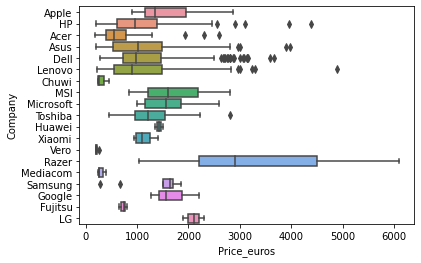

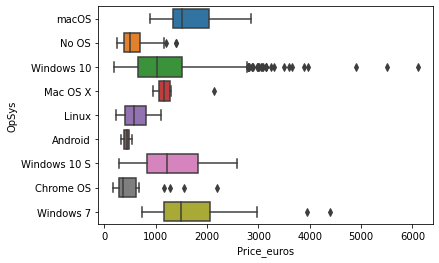

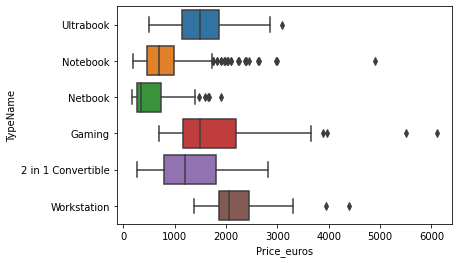

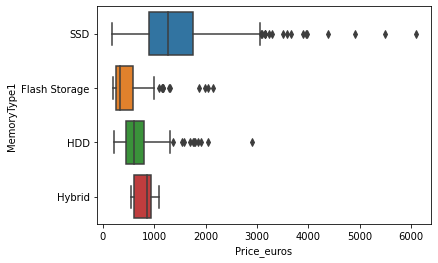

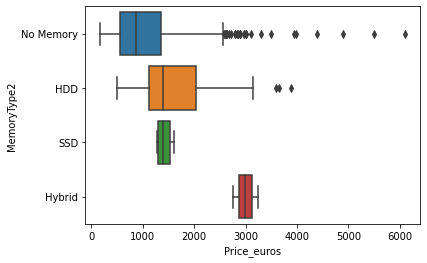

<AxesSubplot:xlabel='Price_euros', ylabel='Touchscreen'>

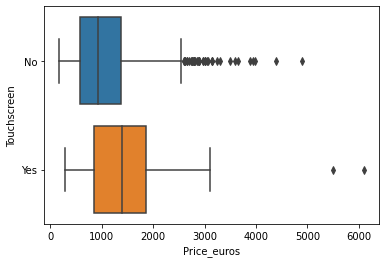

In [16]:
sns.boxplot(x=data.Price_euros, y=data.Company)
plt.show()

sns.boxplot(x=data.Price_euros, y=data.OpSys)
plt.show()

sns.boxplot(x=data.Price_euros, y=data.TypeName)
plt.show()

sns.boxplot(x=data.Price_euros, y=data.MemoryType1)
plt.show()

sns.boxplot(x=data.Price_euros, y=data.MemoryType2)
plt.show()

sns.boxplot(x=data.Price_euros, y=data.Touchscreen)

<AxesSubplot:>

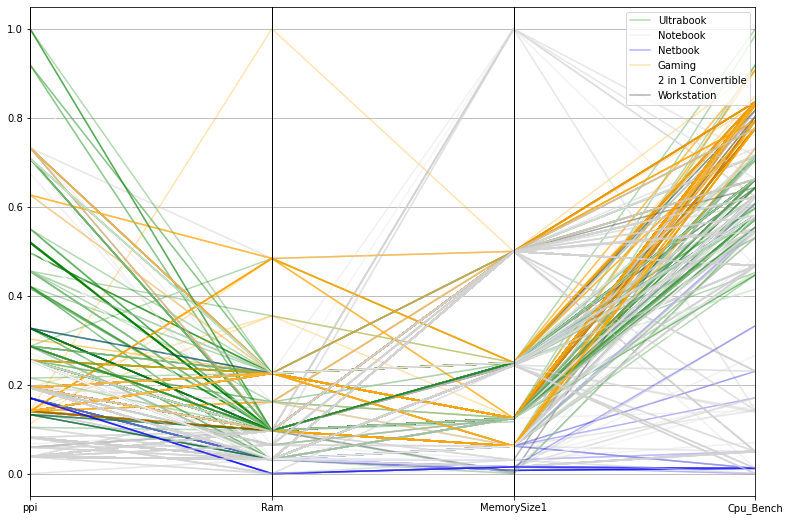

In [18]:
datanorm = data.loc[:,["ppi", "Ram",  "MemorySize1", "Cpu_Bench"]]
datanormnorm=(datanorm-datanorm.min())/(datanorm.max()-datanorm.min())
plt.figure(figsize=(13,9))
pd.plotting.parallel_coordinates(datanormnorm.join(data.TypeName), "TypeName",
                                 color=('green', 'lightgrey', 'blue', 'orange', 'white', 'black'), alpha=0.3)


<AxesSubplot:>

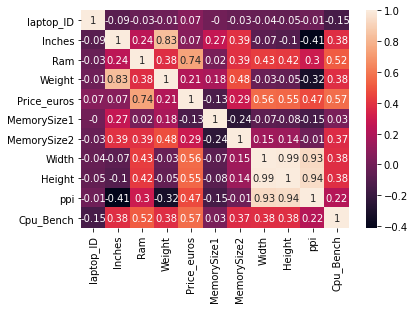

In [19]:
sns.heatmap(data.corr().round(2),  annot=True)

# Regression

In [20]:
data.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,MemoryType1,MemorySize2,MemoryType2,Width,Height,ppi,Touchscreen,Gpu_Model,Cpu_Wname,Cpu_Bench
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128GB SSD,Intel Iris Plus Graphics 640,...,SSD,0.0,No Memory,2560.0,1600.0,226.983005,No,None,Intel Core i5,75.1
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,...,Flash Storage,0.0,No Memory,1440.0,900.0,127.677940,No,None,Intel Core i5,NaN
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256GB SSD,Intel HD Graphics 620,...,SSD,0.0,No Memory,1920.0,1080.0,141.211998,No,None,Intel Core i5 7200U,57.7
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512GB SSD,AMD Radeon Pro 455,...,SSD,0.0,No Memory,2880.0,1800.0,220.534624,No,None,Intel Core i7,79.8
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256GB SSD,Intel Iris Plus Graphics 650,...,SSD,0.0,No Memory,2560.0,1600.0,226.983005,No,None,Intel Core i5,NaN


In [21]:
regdata = data.drop(["laptop_ID", "Product", "Cpu", "Memory", "Gpu", "Width", "Height", "Gpu_Model", "Cpu_Wname", "ScreenResolution"], axis = 1)

In [22]:
regdata.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,MemorySize1,MemoryType1,MemorySize2,MemoryType2,ppi,Touchscreen,Cpu_Bench
0,Apple,Ultrabook,13.3,8.0,macOS,1.37,1339.69,128.0,SSD,0.0,No Memory,226.983005,No,75.1
1,Apple,Ultrabook,13.3,8.0,macOS,1.34,898.94,128.0,Flash Storage,0.0,No Memory,127.677940,No,NaN
2,HP,Notebook,15.6,8.0,No OS,1.86,575.00,256.0,SSD,0.0,No Memory,141.211998,No,57.7
3,Apple,Ultrabook,15.4,16.0,macOS,1.83,2537.45,512.0,SSD,0.0,No Memory,220.534624,No,79.8
4,Apple,Ultrabook,13.3,8.0,macOS,1.37,1803.60,256.0,SSD,0.0,No Memory,226.983005,No,NaN


In [23]:
regdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1303 non-null   object 
 1   TypeName     1303 non-null   object 
 2   Inches       1303 non-null   float64
 3   Ram          1303 non-null   float64
 4   OpSys        1303 non-null   object 
 5   Weight       1303 non-null   float64
 6   Price_euros  1303 non-null   float64
 7   MemorySize1  1303 non-null   float64
 8   MemoryType1  1303 non-null   object 
 9   MemorySize2  1303 non-null   float64
 10  MemoryType2  1303 non-null   object 
 11  ppi          1303 non-null   float64
 12  Touchscreen  1303 non-null   object 
 13  Cpu_Bench    1198 non-null   float64
dtypes: float64(8), object(6)
memory usage: 142.6+ KB


In [24]:
regdatadum = pd.get_dummies(regdata, drop_first=True)

In [25]:
regdatadum.dropna(inplace=True)

In [26]:
Y = regdatadum.Price_euros
X = regdatadum.drop('Price_euros', axis = 1)
X = sm.add_constant(X)

In [27]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=1111)

In [28]:
model_linear = sm.OLS(Y0, X0)
results = model_linear.fit()
results.summary()

/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     81.24
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          6.04e-264
Time:                        16:48:03   Log-Likelihood:                -6445.8
No. Observations:                 898   AIC:                         1.298e+04
Df Residuals:                     856   BIC:                         1.318e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -235.2255    327.362     -0.719      0.473    -877.753     407.302
Inches                  -36.9676     17.845     -2.072      0.039     -71.993      -1.942
Ram                      59.3109      3.221     18.414      0.000      52.989      65.633
Weight                  201.3842     38.754      5.196      0.000     125.320     277.449
MemorySize1              -0.0053      0.057     -0.094      0.925      -0.117       0.106
MemorySize2              -0.2002      0.099     -2.021      0.044      -0.395      -0.006
ppi                       2.7983      0.378      7.399      0.000       2.056       3.541
Cpu_Bench                 7.5189      1.506      4.992      0.000       4.562      10.475
Company_Apple           473.7788    180.676      2.622      0.009     119.160     828.398
Company_Asus             96.9865     53.586      1.810      0.071      -8.189     202.162
Company_Chuwi          -216.4624    243.091     -0.890      0.373    -693.587     260.662
Company_Dell             99.5401     46.840      2.125      0.034       7.605     191.475
Company_Fujitsu          87.4419    233.788      0.374      0.708    -371.423     546.307
Company_Google           2.1e-13   2.42e-13      0.869      0.385   -2.64e-13    6.84e-13
Company_HP              190.6080     49.007      3.889      0.000      94.420     286.796
Company_Huawei          179.9551    329.687      0.546      0.585    -467.135     827.045
Company_LG             1015.3793    239.217      4.245      0.000     545.858    1484.901
Company_Lenovo          173.7244     49.018      3.544      0.000      77.515     269.934
Company_MSI             250.3364     76.080      3.290      0.001     101.011     399.662
Company_Mediacom       -111.0538    144.879     -0.767      0.444    -395.413     173.306
Company_Microsoft       407.2650    171.362      2.377      0.018      70.927     743.603
Company_Razer          1996.3516    161.195     12.385      0.000    1679.967    2312.736
Company_Samsung         268.3202    170.050      1.578      0.115     -65.443     602.084
Company_Toshiba         339.0335     71.139      4.766      0.000     199.407     478.660
Company_Vero              3.4148    202.244      0.017      0.987    -393.538     400.367
Company_Xiaomi          278.8330    201.155      1.386      0.166    -115.982     673.648
TypeName_Gaming        -259.5895     86.808     -2.990      0.003    -429.971     -89.208
TypeName_Netbook       -220.9969    105.727     -2.090      0.037    -428.512     -13.482
TypeName_Notebook      -299.4330     69.687     -4.297      0.000    -436.211    -162.655
TypeName_Ultrabook       60.5114     69.497      0.871      0.384     -75.892     196.915
TypeName_Workstation    584.9192    111.031      5.268      0.000     366.993     802.845
OpSys_Chrome OS        

In [29]:
Y1_pred=results.predict(X1)
print('R^2_test:', r2_score(Y1, Y1_pred))

R^2_test: 0.6428240231350537


## Lasso

In [353]:
reg = linear_model.Lasso(fit_intercept=False, alpha = 0.1).fit(X0, Y0)
print('R^2_train:', reg.score(X0, Y0))
print('R^2_test:', reg.score(X1, Y1))

R^2_train: 0.7733257909160516
R^2_test: 0.7440872133577369


/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47506878.05049449, tolerance: 156333.31805836997
  positive)


In [354]:
coef = pd.DataFrame(dict(zip(X0.columns, reg.coef_)), index=[0]).T
coef.columns=['coef']
coef

,coef
const,-368.770272
Inches,-15.093222
Ram,56.785876
Weight,171.224037
MemorySize1,0.023565
MemorySize2,-0.061201
ppi,3.110467
Cpu_Bench,7.006011
Company_Apple,317.588620
Company_Asus,65.568559


In [32]:
residuals2=results.resid
residuals2.head(10)

1001    103.217747
920     165.119561
580      67.078559
433    -425.518777
76     -168.587890
1111   -132.008582
1162   -285.673497
1011    423.941450
800    -208.351631
385     781.800374
dtype: float64

In [33]:
pred_values=results.predict()

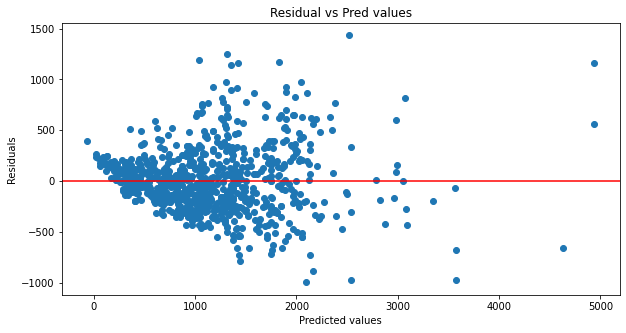

In [34]:
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals2)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [35]:
data[data.MemoryType2 == "SSD"]

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,MemoryType1,MemorySize2,MemoryType2,Width,Height,ppi,Touchscreen,Gpu_Model,Cpu_Wname,Cpu_Bench
28,29,Dell,Latitude 5590,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 8650U 1.9GHz,8.0,256GB SSD + 256GB SSD,Intel UHD Graphics 620,...,SSD,256.0,SSD,1920.0,1080.0,141.211998,No,None,Intel Core i7 8650U,62.5
266,271,Asus,ZenBook Flip,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 8550U 1.8GHz,8.0,512GB SSD + 512GB SSD,Intel UHD Graphics 620,...,SSD,512.0,SSD,1920.0,1080.0,165.632118,Yes,None,Intel Core i7 8550U,63.0
347,353,Dell,Latitude 5590,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 8650U 1.9GHz,16.0,512GB SSD + 256GB SSD,Intel UHD Graphics 620,...,SSD,256.0,SSD,1920.0,1080.0,141.211998,No,None,Intel Core i7 8650U,62.5
901,913,Asus,G701VO-IH74K (i7-6820HK/32GB/2x,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6820HK 2.7GHz,32.0,256GB SSD + 256GB SSD,Nvidia GeForce GTX 980M,...,SSD,256.0,SSD,1920.0,1080.0,127.335675,No,None,Intel Core i7 6820HK,69.7


In [751]:
bnames = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'] 
breush = het_breuschpagan(residuals1, results.model.exog) 
print(list(zip(bnames, breush)))


[('Lagrange multiplier statistic', 179.12210641576368), ('p-value', 6.529589129603978e-18), ('f-value', 5.202163133388702), ('f p-value', 7.244009007248213e-22)]


Homoscedasticity is rejected

In [36]:
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.1616346213537685), ('p-value', 0.06116935153321656)]


Linearity assumption held

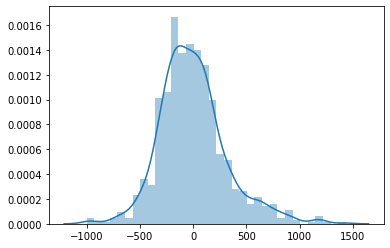

In [37]:
sns.distplot(residuals2)
plt.show()

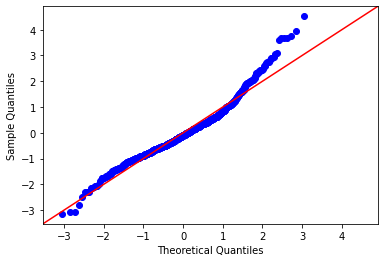

In [38]:
qqplot(residuals2,fit=True, line='45')
plt.show()

In [39]:
snames=['The test statistic', 'p-value']
shapiro2=shapiro(residuals2)
print(list(zip(snames, shapiro2)))

[('The test statistic', 0.9618484377861023), ('p-value', 1.477428409105662e-14)]


By the Shapiro-Wilk test results we reject null hypothesis

## Logarithm

<AxesSubplot:xlabel='Price_euros'>

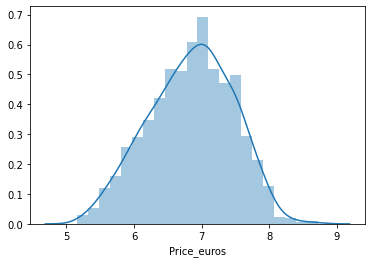

In [49]:
sns.distplot(np.log(data.Price_euros))

In [50]:
Ylog=np.log(Y)

In [51]:
X0, X1, Y0, Y1 = train_test_split(X, Ylog, test_size=0.25, random_state=1111)

In [52]:
reg = linear_model.Ridge(fit_intercept=False).fit(X0, Y0)
print('R^2_train:', reg.score(X0, Y0))
print('R^2_test:', reg.score(X1, Y1))

R^2_train: 0.8242175885275616
R^2_test: 0.80642177809403


In [53]:
coef = pd.DataFrame(dict(zip(X0.columns, reg.coef_)), index=[0]).T
coef.columns=['coef']
coef

,coef
const,3.344560
Inches,0.058641
Ram,0.034727
Weight,-0.020212
MemorySize1,-0.000090
MemorySize2,0.000185
ppi,0.002839
Cpu_Bench,0.020189
Company_Apple,0.423556
Company_Asus,0.112378


In [54]:
residuals1=results.resid
residuals1.head(10)

1001    103.217747
920     165.119561
580      67.078559
433    -425.518777
76     -168.587890
1111   -132.008582
1162   -285.673497
1011    423.941450
800    -208.351631
385     781.800374
dtype: float64

In [55]:
pred_values=results.predict()

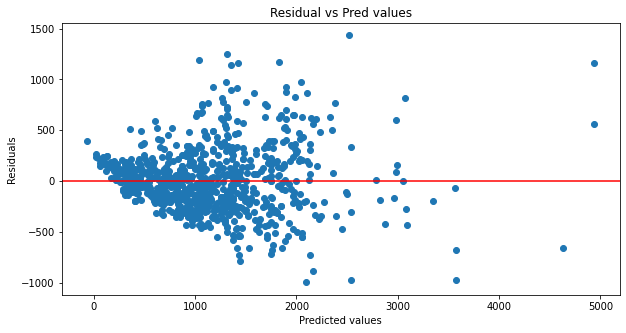

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals1)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [57]:
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.1616346213537685), ('p-value', 0.06116935153321656)]


In [58]:
snames=['The test statistic', 'p-value']
shapiro1=shapiro(residuals1)
print(list(zip(snames, shapiro1)))

[('The test statistic', 0.9618484377861023), ('p-value', 1.477428409105662e-14)]


# Pred of logartihm

In [131]:
Ypredlogtrain = reg.predict(X0)
Ypredlogtest = reg.predict(X1)


In [132]:
Ypredlogtrain = np.exp(Ypredlogtrain)
Ypredlogtest = np.exp(Ypredlogtest)

### Train metics of Linear log

In [133]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y0, Ypredlogtrain))
print('Mean Squared Error:', metrics.mean_squared_error(Y0, Ypredlogtrain))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y0, Ypredlogtrain)))

Mean Absolute Error: 247.4298305296365
Mean Squared Error: 150257.794003191
Root Mean Squared Error: 387.63100237621734


In [134]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y1, Ypredlogtest))
print('Mean Squared Error:', metrics.mean_squared_error(Y1, Ypredlogtest))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y1, Ypredlogtest)))

Mean Absolute Error: 248.48056967820477
Mean Squared Error: 131128.31847561777
Root Mean Squared Error: 362.11644325495325


# Descision tree


In [684]:
dt=DecisionTreeRegressor(random_state=42)
dt.fit(X0,Y0)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [690]:
param_dt={"max_depth":range(1,15),"min_samples_leaf":range(10,150,10)}

In [691]:
dt = DecisionTreeRegressor()
gs_dt=GridSearchCV(estimator=dt,param_grid=param_dt,scoring="r2",n_jobs=-1)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 150, 10)},
             pre_dispatch='2*n_jobs'

In [693]:
best_paramsdt = gs_dt.best_params_

In [698]:
best_paramsdt

{'max_depth': 11, 'min_samples_leaf': 10}

In [695]:
dt_model = DecisionTreeRegressor(random_state=42, max_depth=best_paramsdt["max_depth"],
                                  min_samples_leaf=best_paramsdt["min_samples_leaf"]).fit(X0,Y0)

In [697]:
dt_model.score(X0,Y0)

0.8333175969151417

In [696]:
dt_model.score(X1,Y1)


0.6883308566530917

In [704]:
Ypredtraindt = rf_grid.predict(X0)

In [705]:
Ypredtestdt = dt_model.predict(X1)

### Train metrics of Decision Tree

In [747]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y0, Ypredtraindt))
print('Mean Squared Error:', metrics.mean_squared_error(Y0, Ypredtraindt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y0, Ypredtraindt)))

Mean Absolute Error: 138.500499882673
Mean Squared Error: 49263.6820306496
Root Mean Squared Error: 221.9542340903854


### Test metrics of Decision tree

In [708]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y1, Ypredtestdt))
print('Mean Squared Error:', metrics.mean_squared_error(Y1, Ypredtestdt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y1, Ypredtestdt)))

Mean Absolute Error: 265.3191739655511
Mean Squared Error: 163214.15201689515
Root Mean Squared Error: 403.9977128857231


<AxesSubplot:>

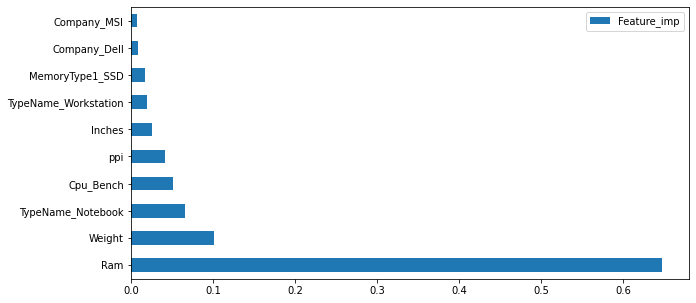

In [761]:
dt_model.feature_importances_
feat_imp=pd.DataFrame(dt_model.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head(10).plot(kind = "barh", figsize = (10,5))

# Random Forest

In [79]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [139]:
dt = RandomForestRegressor()

In [140]:
param_dt={"max_depth":range(1,15),"min_samples_leaf":range(10,150,10), "n_estimators":range(30,150,10)}

In [142]:
param_dt["max_depth"]

range(1, 15)

In [167]:
rf = GridSearchCV(estimator=dt, param_grid=param_dt,  scoring="r2", n_jobs = 8)
rf.fit(X0, Y0)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [168]:
best_params = rf.best_params_
best_params

{'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 40}

In [169]:
rf_grid = RandomForestRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'],
                               min_samples_leaf = best_params['min_samples_leaf']).fit(X0,Y0)

In [170]:
Ypredtrain = rf_grid.predict(X0)


In [171]:
Ypredtest = rf_grid.predict(X1)

### Train metrics of Random Forest

In [172]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y0, Ypredtrain))
print('Mean Squared Error:', metrics.mean_squared_error(Y0, Ypredtrain))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y0, Ypredtrain)))

Mean Absolute Error: 184.768459821811
Mean Squared Error: 79065.01614785669
Root Mean Squared Error: 281.18502120108866


### Test metrics of Random forest

In [173]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y1, Ypredtest))
print('Mean Squared Error:', metrics.mean_squared_error(Y1, Ypredtest))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y1, Ypredtest)))

Mean Absolute Error: 250.115194153055
Mean Squared Error: 161838.09963477636
Root Mean Squared Error: 402.2910633294957


In [174]:
rf_grid.score(X0,Y0)

0.8277338708972837

In [175]:
rf_grid.score(X1,Y1)

0.6909585274882227

<AxesSubplot:>

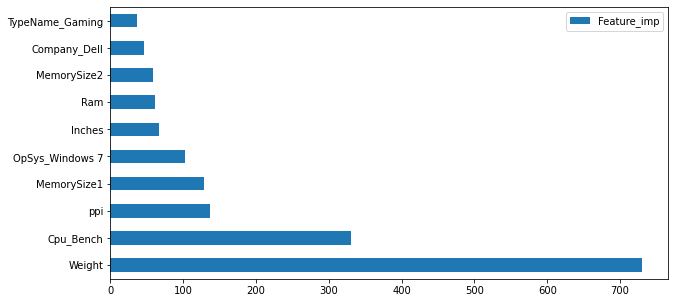

In [759]:
rf_grid.feature_importances_
feat_imp=pd.DataFrame(rf_grid.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head(10).plot(kind = "barh",figsize = (10,5))

# Gradient boost

In [220]:
from lightgbm import LGBMRegressor


In [346]:
param_dt={"max_depth":range(4,17),
          "min_samples_leaf":range(10,100,10), 
          "n_estimators":range(150,450,10),
          'learning_rate': np.linspace(0.001,0.01, 5)}

In [347]:
model = LGBMRegressor()

In [348]:
grid_gb = GridSearchCV(estimator=model, param_grid=param_dt,scoring=  "r2", n_jobs=8)
grid_gb.fit(X0,Y0)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=8,
             param_grid={'learning_rate': array([0.001  , 0.00325, 0.0055 , 0.00775, 0.01   ]),
                         'max_depth': range(4, 17),
                         'min_sa

In [355]:
gb_bestparams = grid_gb.best_params_

In [356]:
gb_bestparams

{'learning_rate': 0.01,
 'max_depth': 14,
 'min_samples_leaf': 10,
 'n_estimators': 440}

In [729]:
gbm_grid = LGBMRegressor(max_depth=gb_bestparams['max_depth'], 
                        n_estimators=gb_bestparams['n_estimators'],
                        min_samples_leaf = gb_bestparams['min_samples_leaf'],
                       learning_rate=gb_bestparams["learning_rate"]).fit(X0,Y0)

In [730]:
gbm_grid.score(X0,Y0)

0.8926647432424878

In [731]:
gbm_grid.score(X1,Y1)

0.7611724151138944

In [735]:
gbm_hand = LGBMRegressor(max_depth=3, 
                        n_estimators=400,
                        min_samples_leaf = 2000,
                       learning_rate=0.25).fit(X0,Y0)

In [736]:
gbm_hand.score(X0,Y0)

0.9413115746472417

In [737]:
gbm_hand.score(X1,Y1)


0.8532661271114128

In [740]:
Ypredtrain_gbm = gbm_hand.predict(X0)


In [742]:
Ypredtest_gbm = gbm_hand.predict(X1)

### Train metrics of GBM

In [745]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y0, Ypredtrain_gbm))
print('Mean Squared Error:', metrics.mean_squared_error(Y0, Ypredtrain_gbm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y0, Ypredtrain_gbm)))

Mean Absolute Error: 117.05090255995458
Mean Squared Error: 26936.237102311195
Root Mean Squared Error: 164.12262824580648


### Train metrics of GBM

In [746]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y1, Ypredtest_gbm))
print('Mean Squared Error:', metrics.mean_squared_error(Y1, Ypredtest_gbm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y1, Ypredtest_gbm)))

Mean Absolute Error: 183.83269078440463
Mean Squared Error: 76841.24382184594
Root Mean Squared Error: 277.20253213462166


<AxesSubplot:>

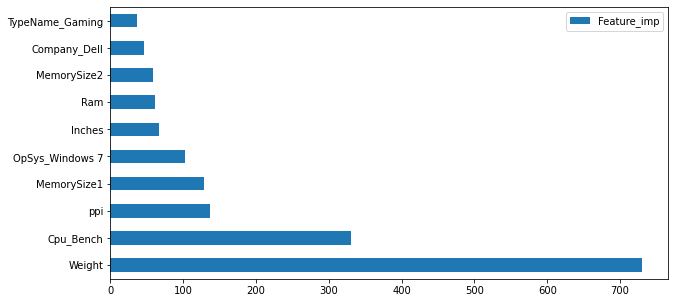

In [760]:
gbm_hand.feature_importances_
feat_imp=pd.DataFrame(gbm_hand.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head(10).plot(kind = "barh",figsize = (10,5))

<AxesSubplot:>

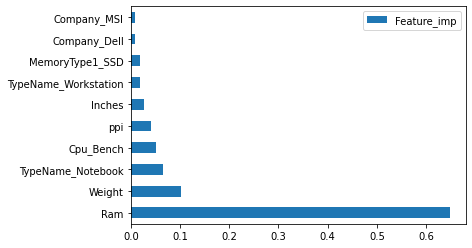

In [772]:
feat_imp.head(10).plot(kind = "barh")